In [2]:
from glob import glob
import pandas as pd

In [3]:
def parse_fname(fname: str) -> dict:
    parsed = dict()
    options = fname.split('@')[1]
    options = options.split('.csv')[0]
    for c in options.split(','):
        k, val = c.split('_')
        parsed[k] = val
        
    score = fname.split('results\\')[1].split('@')[0].split('_')[0]
    return parsed, score

records = list()
y = list()
for fname in glob('results/*.csv'):
    opts, score = parse_fname(fname)
    records.append(opts)
    y.append(float(score))

df = pd.DataFrame.from_records(records)
X = pd.get_dummies(df, columns=['seg', 'sel', 'reg'], drop_first=False)
X.weights = X.weights.apply(lambda r: r == 'true')

In [4]:
from sklearn.linear_model import LinearRegression

clf = LinearRegression()
clf.fit(X, y)
list(sorted(zip(X.columns, clf.coef_), key=lambda x: -abs(x[1])))

[('reg_lasso', -0.10449663628472233),
 ('reg_ridge', 0.0619149848090277),
 ('reg_linear', 0.042581651475694364),
 ('seg_quickshift', 0.021745117187500065),
 ('seg_felzenszwalb', -0.0217451171874999),
 ('sel_auto', -0.01822054036458335),
 ('sel_3', 0.018220540364583294),
 ('weights', 0.0016235677083333289),
 ('n', 0.00021822656249999718)]

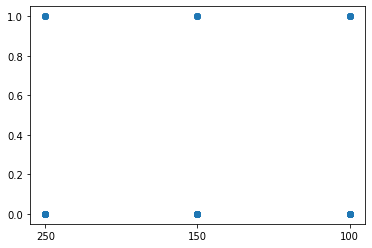

In [5]:
import matplotlib.pyplot as plt

plt.scatter(X.n, X.reg_lasso)

In [6]:
for n,grp in df.query('sel == "auto"').groupby('reg'):
    print(n, len(grp))

lasso 1
linear 12
ridge 12


In [7]:
df.columns

Index(['n', 'seg', 'reg', 'sel', 'weights'], dtype='object')

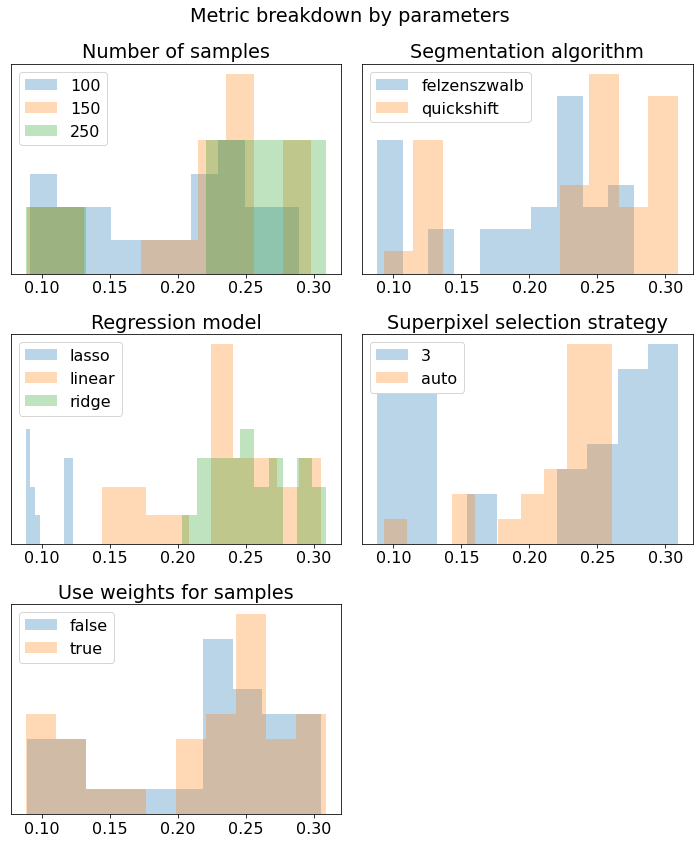

In [15]:
from math import ceil
grps = ['n', 'seg', 'reg', 'sel', 'weights']
names = ['Number of samples', 'Segmentation algorithm', 'Regression model',
        'Superpixel selection strategy', 'Use weights for samples']

plt.figure(figsize=(10,12))
plt.rcParams.update({'font.size': 16})
for i,(name,G) in enumerate(zip(names,grps)):
    plt.subplot(ceil(len(grps) / 2), 2, i+1)
    for n,grp in df.assign(y=y).groupby(G):
        # print(len(grp))
        plt.hist(grp.y, alpha=0.3, label=n)
        plt.title('%s' % name)
        # plt.xlim(0, 0.4)
        plt.legend(loc='best')
        plt.yticks([])
plt.suptitle('Metric breakdown by parameters')
plt.tight_layout()
plt.savefig('figs/Histograms.pdf')
plt.show()

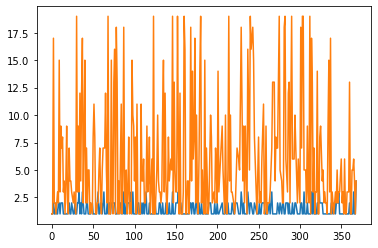

In [37]:
import matplotlib.pyplot as plt
df = pd.read_csv('results_old/0.252_results@seg_quickshift,sel_auto,n_200,reg_linear,weights_true.csv')
df = df.dropna()
plt.plot(df.num_top_features, label='Selected')
plt.plot(df.best_score_num_fts, label='Optimal')
plt.show()

In [38]:
len(df.query('num_top_features < best_score_num_fts')) / len(df)

0.7261904761904762

In [39]:
len(df.query('num_top_features == best_score_num_fts')) / len(df)

0.21726190476190477

In [40]:
len(df.query('num_top_features == best_score_num_fts or num_top_features+1 == best_score_num_fts')) / len(df)

0.33035714285714285

In [41]:
len(df.query('num_top_features > best_score_num_fts')) / len(df)

0.05654761904761905

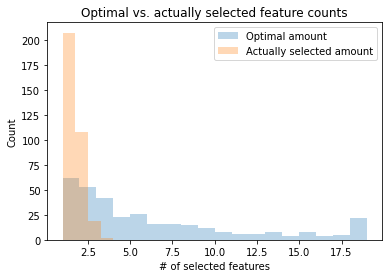

In [42]:
plt.hist(df.best_score_num_fts, alpha=0.3, bins=range(1,20), label='Optimal amount')
plt.hist(df.num_top_features, alpha=0.3, bins=4, label='Actually selected amount')
plt.legend(loc='best')
plt.xlabel('# of selected features')
plt.ylabel('Count')
plt.title('Optimal vs. actually selected feature counts')
plt.show()

In [44]:
df.query('num_top_features < 1')

,Unnamed: 0,score,label,num_top_features,area_ratio,idx,best_score,best_score_num_fts
